# **Tải dữ liệu** 

In [1]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


# Import thư viện cần thiết


In [2]:
import numpy as np
import time
from random import randint
from google.colab.patches import cv2_imshow
np.random.seed()

# Quan sát dữ liệu

In [3]:
x_train = X_train.reshape(len(X_train), 28*28)
x_test = X_test.reshape(len(X_test), 28*28)
x_train = x_train / 255.
x_test = x_test / 255.

In [ ]:
cv2_imshow(X_train[1])

In [ ]:
y_train.shape

(60000,)

In [ ]:
x_train.shape

(60000, 784)

In [ ]:
x_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
y_train[0]

5

# Tạo model


In [4]:
class NN:
    first_layer = {}
    second_layer = {}

    def __init__(self, inputs, hidden, outputs):
        self.first_layer['weight'] = np.random.randn(inputs, hidden) / np.sqrt(inputs)
        self.first_layer['bias'] = np.random.randn(hidden, 1) / np.sqrt(hidden)
        self.second_layer['weight'] = np.random.randn(hidden, outputs) / np.sqrt(hidden)
        self.second_layer['bias'] = np.random.randn(outputs, 1) / np.sqrt(outputs)
      
        self.input_size = inputs
        self.hid_size = hidden
        self.output_size = outputs

    def activfunc(self, Z, type = 'ReLU', deri = False):
        if type == 'ReLU':
            if deri == True: # neu co dao ham
                return np.array([1 if i > 0 else 0 for i in np.squeeze(Z)])
            else:
                return np.array([i if i > 0 else 0 for i in np.squeeze(Z)])
        elif type == 'Sigmoid':
            if deri == True:
                return 1/(1+np.exp(-Z))*(1-1/(1+np.exp(-Z)))
            else:
                return 1/(1+np.exp(-Z))
        elif type == 'tanh':
            if deri == True:
                return 
            else:
                return 1-(np.tanh(Z))**2
        else:
            raise TypeError('Invalid type!')

    def Softmax(self,z):
        return 1/sum(np.exp(z)) * np.exp(z)

    def cross_entropy_error(self, y_hat, y):
        return -np.log(y_hat[y])

    def feedforward(self,x,y):
        Z1 = np.dot(self.first_layer['weight'].T, x).reshape((self.hid_size,1)) + self.first_layer['bias'] # Z[1] = W[1] * X + b[1]
        A1 = np.array(self.activfunc(Z1)).reshape((self.hid_size,1)) # A[1] = sigmoid(Z[1])
        Z2 = np.dot(self.second_layer['weight'].T, A1).reshape((self.output_size,1)) + self.second_layer['bias'] # Z[2] = W[2] * A[1] + b[2]
        y_hat = np.squeeze(self.Softmax(Z2))
        error = self.cross_entropy_error(y_hat,y)
        para = {
            'Z1': Z1,
            'A1': A1,
            'Z2': Z2,
            'y_hat': y_hat,
            'error': error
        }
        return para

    def predict(self, x):
        return np.argmax(self.feedforward(x, 1)['y_hat'])

    def back_propagation(self, x, y, f_result):
        # onehot encoder cho y
        E = np.array([0]*self.output_size).reshape((1, self.output_size))
        E[0][y] = 1
        dtmp = (f_result['y_hat'] - E).reshape((self.output_size,1)) 
        db2 = dtmp
        dW2 = np.dot(dtmp, f_result['A1'].T)
        delta = np.dot(self.second_layer['weight'], dtmp) * self.activfunc(f_result['Z1'], deri = True).reshape(self.hid_size, 1)
        db1 = delta
        dW1 = np.dot(db1.reshape((self.hid_size, 1)),x.reshape((1, 784)))

        grad = {
            'dW2':dW2,
            'db2':db2,
            'db1':db1,
            'dW1':dW1
        }
        return grad

    def optimize(self,b_result, learning_rate):
        self.second_layer['weight'] -= learning_rate*b_result['dW2'].T
        self.second_layer['bias'] -= learning_rate*b_result['db2']
        self.first_layer['weight'] -= learning_rate*b_result['dW1'].T
        self.first_layer['bias'] -= learning_rate*b_result['db1']


    def loss(self,X_train,Y_train):
        loss = 0
        for n in range(len(X_train)):
            y = Y_train[n]
            x = X_train[n][:]
            loss += self.feedforward(x,y)['error']
        return loss / len(X_train)

    def train(self, X_train, Y_train, num_iterations = 1000, learning_rate = 0.5):
        # generate random list index for train
        rand_indices = np.random.choice(len(X_train), num_iterations, replace=True)
        
        def l_rate(base_rate, ite, num_iterations, schedule = False):
        # determine whether to use the learning schedule
            if schedule == True:
                return base_rate * 10 ** (-np.floor(ite/num_iterations*5))
            else:
                return base_rate

        count = 1
        loss_dict = {}
        test_dict = {}
        num_epochs = 1
        for i in rand_indices:
            f_result = self.feedforward(X_train[i], Y_train[i])
            b_result = self.back_propagation(X_train[i], Y_train[i], f_result)
            self.optimize(b_result, l_rate(learning_rate, i, num_iterations, True))
            
            if count % 1000 == 0:
                print('Trained for {} times,'.format(count))
                if count % 5000 == 0:
                    loss = self.loss(X_train,Y_train)
                    test, wrong_case = self.testing(x_test,y_test)
                    print('Trained for {} epoch(s),'.format(num_epochs),'loss = {}, test = {}'.format(loss,test))
                    loss_dict[str(count)]=loss
                    test_dict[str(count)]=test
                    num_epochs += 1
                    
            count += 1

        print('Training finished!')
        return loss_dict, test_dict

    def testing(self, X_test, y_test):
        wrong_case = []
        total_correct = 0
        for n in range(len(X_test)):
            y = y_test[n]
            x = X_test[n][:]
            prediction = np.argmax(self.feedforward(x, y)['y_hat'])
            if (prediction == y):
                total_correct += 1
            else: wrong_case.append(n)
        print('Accuarcy Test: ',total_correct / len(X_test))
        return total_correct/np.float(len(X_test)), wrong_case

## Test thử các trường hợp khác nhau của hidden size

In [ ]:
num_iterations = 200000
learning_rate = 0.01
num_inputs = 28*28
num_outputs = 10
hidden_size = [32, 64, 128, 256, 512]
acc_per_hidden_size = []
# data fitting, training and accuracy evaluation
for i in hidden_size:
  model = NN(num_inputs, i, num_outputs)
  cost_dict, tests_dict = model.train(x_train, y_train, num_iterations=num_iterations, learning_rate=learning_rate)
  tmp, _ = model.testing(x_test, y_test)
  acc_per_hidden_size.append(tmp)

Trained for 1000 times,
Trained for 2000 times,
Trained for 3000 times,
Trained for 4000 times,
Trained for 5000 times,


KeyboardInterrupt: ignored

In [5]:
num_iterations = 300000
learning_rate = 0.01
num_inputs = 28*28
num_outputs = 10
hidden_size = 512
acc_per_hidden_size = []
# data fitting, training and accuracy evaluation
model = NN(num_inputs, hidden_size, num_outputs)
cost_dict, tests_dict = model.train(x_train, y_train, num_iterations=num_iterations, learning_rate=learning_rate)
tmp, _ = model.testing(x_test, y_test)
acc_per_hidden_size.append(tmp)

Trained for 1000 times,
Trained for 2000 times,
Trained for 3000 times,
Trained for 4000 times,
Trained for 5000 times,
Accuarcy Test:  0.8962
Trained for 1 epoch(s), loss = 0.3692832654266917, test = 0.8962


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Trained for 6000 times,
Trained for 7000 times,
Trained for 8000 times,
Trained for 9000 times,
Trained for 10000 times,
Accuarcy Test:  0.9319
Trained for 2 epoch(s), loss = 0.2466527180132791, test = 0.9319
Trained for 11000 times,
Trained for 12000 times,
Trained for 13000 times,
Trained for 14000 times,
Trained for 15000 times,
Accuarcy Test:  0.9384
Trained for 3 epoch(s), loss = 0.21250576905223176, test = 0.9384
Trained for 16000 times,
Trained for 17000 times,
Trained for 18000 times,
Trained for 19000 times,
Trained for 20000 times,
Accuarcy Test:  0.9413
Trained for 4 epoch(s), loss = 0.19919896817518723, test = 0.9413
Trained for 21000 times,
Trained for 22000 times,
Trained for 23000 times,
Trained for 24000 times,
Trained for 25000 times,
Accuarcy Test:  0.9509
Trained for 5 epoch(s), loss = 0.16260238325042237, test = 0.9509
Trained for 26000 times,
Trained for 27000 times,
Trained for 28000 times,
Trained for 29000 times,
Trained for 30000 times,
Accuarcy Test:  0.9415
T

In [6]:
accuracy, wrong_case = model.testing(x_test,y_test)

Accuarcy Test:  0.9782


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


## Visualize một số trường hợp sai

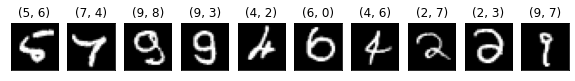

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=10, sharex=False, 
    sharey=True, figsize=(10, 4))
for i in range(10):
    axes[i].set_title((y_test[wrong_case[i]], model.predict(x_test[wrong_case[i]])))
    axes[i].imshow(X_test[wrong_case[i]], cmap='gray')
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
plt.show()

## Dự đoán 


In [ ]:
model.predict(x_test[11])

6

In [ ]:
y_test[11]

6

In [ ]:
cv2_imshow(X_test[11])

In [ ]:
for i in range(len(hidden_size)):
  print("Accuracy for %d hidden size: %0.3f" % (hidden_size[i], acc_per_hidden_size[i]))

## So sánh các iteration khác nhau

In [ ]:
cost = []
acc = []
num_iter = []
for i in cost_dict:
  num_iter.append(i)
  cost.append(cost_dict[i])
for i in tests_dict:
  acc.append(tests_dict[i])

iteration = 10000: loss = 0.288, accuracy = 0.917%
iteration = 20000: loss = 0.212, accuracy = 0.936%
iteration = 100000: loss = 0.105, accuracy = 0.961%
iteration = 200000: loss = 0.057, accuracy = 0.975%


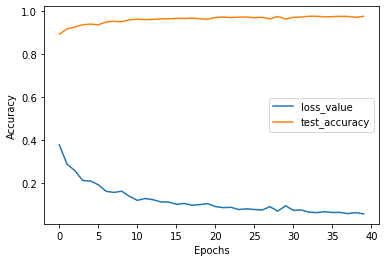

In [ ]:
print("iteration = %d: loss = %0.3f, accuracy = %0.3f%s" %(10000, cost_dict['10000'], tests_dict['10000'], '%'))
print("iteration = %d: loss = %0.3f, accuracy = %0.3f%s" %(20000, cost_dict['20000'], tests_dict['20000'], '%'))
print("iteration = %d: loss = %0.3f, accuracy = %0.3f%s" %(100000, cost_dict['100000'], tests_dict['100000'], '%'))
print("iteration = %d: loss = %0.3f, accuracy = %0.3f%s" %(200000, cost_dict['200000'], tests_dict['200000'], '%'))

plt.plot(cost, label='loss_value')
plt.plot(acc, label='test_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()